In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
v1 = gpd.read_file('../ActiveFire/fire_nrt_J1V-C2_346197.shp')
v2 = gpd.read_file('../ActiveFire/fire_nrt_SV-C2_346198.shp')
viirs = pd.concat([v1,v2], axis=0)
ptt = gpd.read_file('../Shapefile/prov_ปทุมธานี.shp', encoding='TIS-620')
land_ptt = gpd.read_file('../Shapefile/LU_PTT_2562.shp', encoding='TIS-620')
grid_ptt = gpd.read_file('../Shapefile/PTT_Grid.shp', encoding='TIS-620')
ptt.to_crs('EPSG:4326', inplace = True)
land_ptt.to_crs('EPSG:4326', inplace = True)
grid_ptt.to_crs('EPSG:4326', inplace = True)
grid_ptt['Id'] = np.arange(0,grid_ptt.shape[0],1)
ef = pd.read_excel(f'../Data/Emission_factor_realtime.xlsx', sheet_name='EF_New_viirs')
ef.set_index('LU_CODE', inplace=True) #kg/point
ef = ef/3 # the fire with six hours

In [4]:
viirs['Date_Time'] = viirs['ACQ_DATE'] + ' ' + viirs['ACQ_TIME']
viirs['Date_Time'] = pd.to_datetime(viirs['Date_Time'], format='%Y-%m-%d %H%M') +  pd.Timedelta(hours=7)

In [5]:
# =============================================================================
# Intersection landuse and grid ID
# =============================================================================
active_ptt = viirs.overlay(land_ptt, how = 'intersection')
active_ptt = active_ptt.overlay(grid_ptt, how = 'intersection')
active_ptt.drop(columns=['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE', 'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'LU_ID_L1', 'LU_ID_L2', 'LU_ID_L3', 'LU_DES_TH', 'LU_DES_EN', 'LUL1_CODE', 'LUL2_CODE', 'LU_DES', 'RAI', 'geometry'], inplace = True)
list_ef = list(ef.columns)
for i in list_ef:
    active_ptt[i] = np.nan
# =============================================================================
# Calculation emission
# =============================================================================
for pol in list_ef:
    for i in active_ptt.index:
        if active_ptt['LU_CODE'].iloc[i] in ef.index:
            active_ptt[pol].iloc[i] = ef[pol].loc[active_ptt['LU_CODE'].iloc[i]]
        else:
            active_ptt[pol].iloc[i] = ef[pol].loc['A101']

In [6]:
active_ptt['Date_Time'] = active_ptt['Date_Time'].dt.floor('H')
active_ptt = active_ptt.groupby(['Date_Time', 'Id']).sum()
active_ptt.sort_index(inplace = True)
active_ptt.reset_index(inplace=True)
active_ptt.set_index('Date_Time', inplace = True, drop = True)
date_range = pd.date_range(start=active_ptt.index[0], end=active_ptt.index[-1], freq='H')
emission_combine = pd.DataFrame()
for time in date_range:
    time_start = time
    time_stop = time + pd.Timedelta(hours=2)
    list_time = pd.date_range(start=time_start, end = time_stop, freq='H')
    for time1 in list_time:
        try:
            tem = active_ptt.loc[str(time)]
            tem['Date_Time'] = time1
            tem.set_index('Date_Time', inplace = True, drop = True)
            emission_combine = pd.concat([emission_combine, tem], axis = 0)
        except:
            pass
emission_combine.reset_index(inplace=True)
emission_combine = emission_combine.groupby(['Date_Time', 'Id']).sum()
emission_combine.reset_index(inplace=True)
emission_combine.set_index('Date_Time', inplace = True, drop = True)

In [7]:
date_range1 = pd.date_range(start=emission_combine.index[0], end=emission_combine.index[-1], freq='H')
for time in date_range1:
    a = str(time)
    try:
        tem = pd.merge(grid_ptt, emission_combine.loc[time], left_on = 'Id', right_on ='Id')
        for pol in list_ef:
            fig, ax = plt.subplots(figsize=(30,20), dpi=200)
            plt.rcParams['font.size'] = '24'
            tem.plot(column=pol,
                        ax=ax,
                        # vmax=vmax,
                        legend=True,
                        legend_kwds={
                            "shrink":.73
                        })#, cmap='YlOrRd'

            grid_ptt.plot(ax=ax, color='none', edgecolor='whitesmoke')
            ptt.plot(ax=ax, color='none', edgecolor='red')
            ax.set_title(f'{pol}_{a[:10]}_{a[11:13]}:00 (kg)');
            ax.set_xlim([100.325, 100.96])
            ax.set_ylim([13.91, 14.29])
            fig.savefig(rf'../Activefire_picture/{pol}_{a[:10]}_{a[11:13]}_00.png', bbox_inches = 'tight')
    except:
        pass


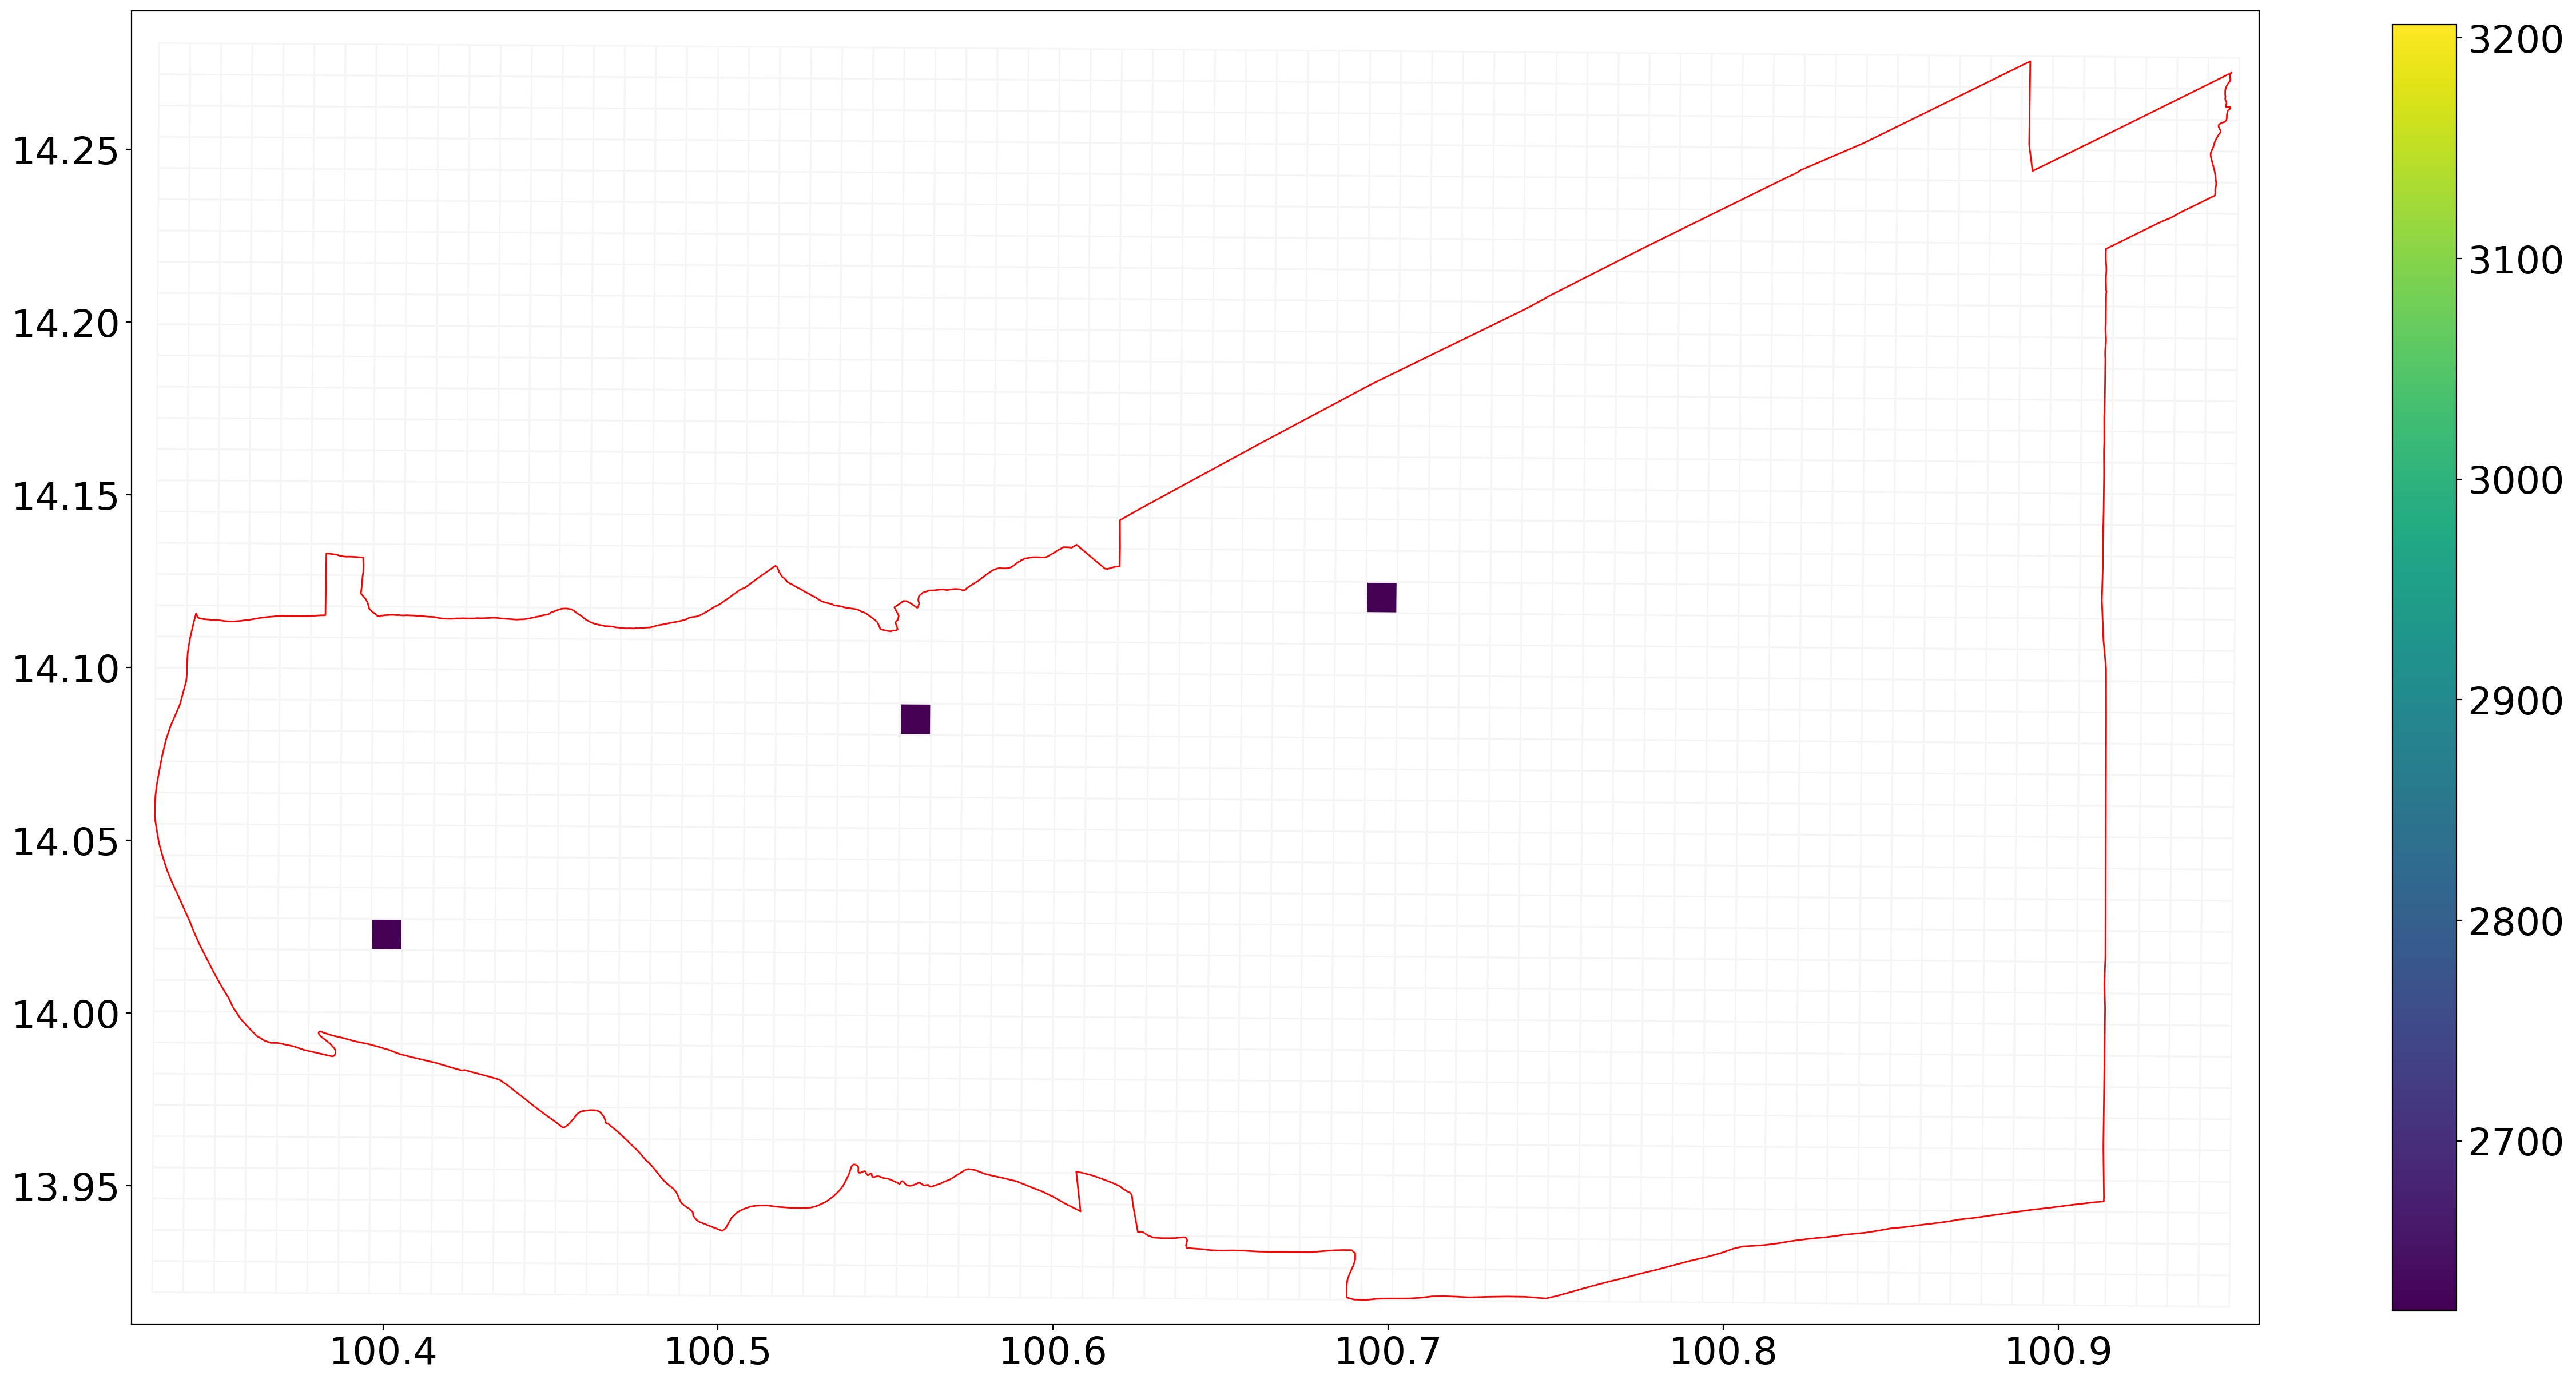

In [23]:
fig, ax = plt.subplots(figsize=(30,20), dpi=200)
plt.rcParams['font.size'] = '24'
tem.plot(column='CO',
            ax=ax,
            # vmax=vmax,
            legend=True,
            legend_kwds={
                "shrink":.73
            })#, cmap='YlOrRd'

grid_ptt.plot(ax=ax, color='none', edgecolor='whitesmoke')
ptt.plot(ax=ax, color='none', edgecolor='red')
# ax.set_title(f'{d}_{c[:8]}_{c[-4:-2]}:{c[-2:]}(g/hr)');
ax.set_xlim([100.325, 100.96])
ax.set_ylim([13.91, 14.29])
fig.savefig(rf'test.png', bbox_inches = 'tight')